In [38]:
# This notebook takes the pickled eval results and computes the metrics. 
# Simply provide the path to the pickle in the 'pickle_location' and run the entire notebook

import pickle
from scipy.special import softmax
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt

pickle_location = 'ast-finetuned-audioset-10-10-0.4593-bs8-lr5e-06/checkpoint-24000/logits_labels_soundscape.pkl'

# Open the file in binary read mode
with open(pickle_location, 'rb') as file:
    # Load the data using pickle
    data = pickle.load(file)

logits = data['logits'][0]
labels = data['labels'][0]
id2label = data['id2label']

present_classes = np.unique(labels)

# Filter the prob array to include only the columns corresponding to present classes
logits = logits[:, present_classes]

# Re-map labels to match the filtered columns in prob
labels = np.array([np.where(present_classes == label)[0][0] for label in labels])

id2label = {str(new_id): id2label[str(old_id)] for new_id, old_id in enumerate(present_classes)}

n_classes = len(present_classes)
label2id = {}
for key, val in id2label.items(): label2id[val] = key

print('id2label: ', id2label)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))
prob = softmax(logits, axis=-1)
prob_sigmoid = sigmoid(logits)
pred = np.argmax(logits, axis=-1)

print('MultiClass:')
precision = precision_score(labels, pred, average='macro', zero_division=1)
print(f"Precision: {precision}")
recall = recall_score(labels, pred, average='macro')
print(f"Recall: {recall}")
f1 = f1_score(labels, pred, average='macro')
print(f"F1 Score: {f1}")
roc_auc = roc_auc_score(labels, prob, average='macro', multi_class='ovr')
print(f"ROC AUC: {roc_auc}")

print()
print('MultiLabel:')


labels_onehot = label_binarize(labels, classes=np.arange(logits.shape[1]))
thres = 0.5
prob_threshed = (prob > thres).astype(int)

# Multi-label metrics
precision = precision_score(labels_onehot, prob_threshed, average='macro', zero_division=1)
print(f"Precision: {precision}")
recall = recall_score(labels_onehot, prob_threshed, average='macro')
print(f"Recall: {recall}")
f1 = f1_score(labels_onehot, prob_threshed, average='macro')
print(f"F1 Score: {f1}")
roc_auc = roc_auc_score(labels_onehot, prob, average='macro', multi_class='ovr')
print(f"ROC AUC: {roc_auc}")

id2label:  {'0': 'amabaw1', '1': 'amapyo1', '2': 'bartin2', '3': 'bichaw1', '4': 'blbman1', '5': 'blbwoo1', '6': 'blcman1', '7': 'blctro1', '8': 'blfant1', '9': 'blfant2', '10': 'blfjac1', '11': 'blhpar1', '12': 'blsant1', '13': 'blttro1', '14': 'bratin1', '15': 'brbmot1', '16': 'brratt1', '17': 'bsbeye1', '18': 'btfgle1', '19': 'bucmot4', '20': 'buhmac1', '21': 'butwoo1', '22': 'chbtou1', '23': 'cheara1', '24': 'cintin1', '25': 'coltro1', '26': 'cowpar1', '27': 'crcwoo1', '28': 'crcwoo2', '29': 'ducatt1', '30': 'duhpar', '31': 'dutant2', '32': 'dutfla1', '33': 'dwtman1', '34': 'elewoo1', '35': 'eulfly1', '36': 'fasant1', '37': 'fepowl', '38': 'goctou1', '39': 'gramou1', '40': 'grepot1', '41': 'grfdov1', '42': 'gryant1', '43': 'gryant2', '44': 'grytin1', '45': 'hauthr1', '46': 'jottyr1', '47': 'lahfla2', '48': 'lawthr1', '49': 'lcptyr1', '50': 'lecgre2', '51': 'liffal1', '52': 'littin1', '53': 'lobwoo1', '54': 'lotwoo1', '55': 'meapar', '56': 'obfgle3', '57': 'ocepoo1', '58': 'oliwoo1'

In [40]:
from sklearn.metrics import auc, roc_curve
fpr, tpr, roc_auc = dict(), dict(), dict()

n_classes = logits.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_onehot[:, i], prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 10000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

class_auc = []

for i in range(n_classes):
    class_auc.append((id2label[str(i)], auc(fpr_grid, np.interp(fpr_grid, fpr[i], tpr[i]))))
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation
class_auc.sort(key = lambda a: a[1], reverse=True) 
for cls, area in class_auc:
    print(f'AUC for class {cls}: {area}')


# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print()
print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']}")

AUC for class strant3: 0.9346434643464346
AUC for class secfly1: 0.8916232994095682
AUC for class sbffal1: 0.8865973304992297
AUC for class whnpuf2: 0.8671533820048671
AUC for class goctou1: 0.8593690066145835
AUC for class dutant2: 0.8501660810458264
AUC for class t-11063200: 0.8491682501583492
AUC for class ruwant4: 0.8284078407840784
AUC for class spwant2: 0.7725772577257726
AUC for class plbwoo1: 0.7600052435299315
AUC for class rubpep1: 0.7554255843259012
AUC for class rinwoo1: 0.7522748631057021
AUC for class t-11059964: 0.7264643130979764
AUC for class parjac1: 0.7257990737507056
AUC for class lotwoo1: 0.7221707361183414
AUC for class stbwoo1: 0.7170244487733218
AUC for class lobwoo1: 0.7140732069625438
AUC for class whbtot1: 0.7078374504117079
AUC for class dutfla1: 0.7026509033503493
AUC for class wibpip1: 0.6975616342555557
AUC for class blttro1: 0.678343408201577
AUC for class bsbeye1: 0.6756925692569257
AUC for class lecgre2: 0.6725589225589226
AUC for class vartin1: 0.6641

In [41]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(labels_onehot.ravel(), prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']}")

Micro-averaged One-vs-Rest ROC AUC score:
0.380249352282589


102
2


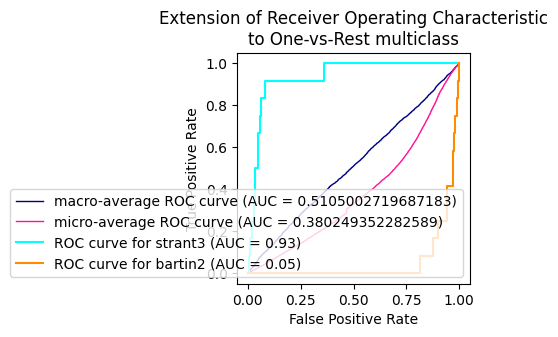

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
%matplotlib inline

fig, ax = plt.subplots(figsize=(3, 3))
plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']})",
    color="navy",
    linewidth=1,
)

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']})",
    color="deeppink",
    linewidth=1,
)

for class_id, color in zip(["strant3", "bartin2"], ["aqua", "darkorange"]):
    class_id = int(label2id[class_id])
    print(class_id)
    RocCurveDisplay.from_predictions(
        labels_onehot[:, class_id],
        prob[:, class_id],
        name=f"ROC curve for {id2label[str(class_id)]}",
        color=color,
        ax=ax,
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
)

In [44]:
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(labels == i, prob[:, i])
    average_precision[i] = average_precision_score(labels == i, prob[:, i])

sorted_classes = sorted(average_precision, key=average_precision.get, reverse=True)
best_classes = sorted_classes[:5]  
worst_classes = sorted_classes[-5:] 

all_precision = np.unique(np.concatenate([precision[i] for i in range(n_classes)]))
mean_recall = np.zeros_like(all_precision)

for i in range(n_classes):
    mean_recall += np.interp(all_precision, precision[i], recall[i])

mean_recall /= n_classes

macro_auc = np.mean(list(average_precision.values()))

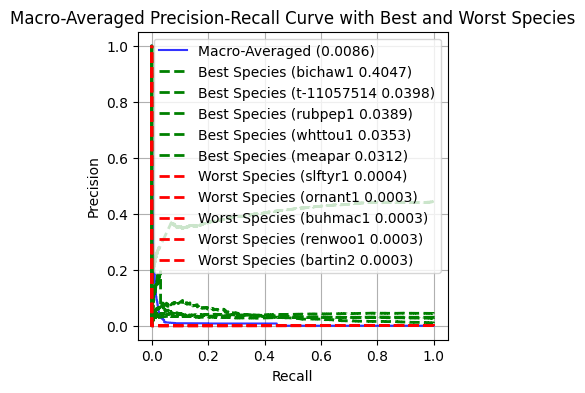

In [46]:
# PR CURVE

plt.figure(figsize=(4, 4))

plt.step(all_precision, mean_recall, where='post', label=f'Macro-Averaged ({macro_auc:.4f})', color='b', alpha=0.8)

for best_class in best_classes:
    plt.plot(recall[best_class], precision[best_class], label=f'Best Species ({id2label[str(best_class)]} {average_precision[best_class]:.4f})', color='g', linestyle='--', lw=2)

for worst_class in worst_classes:
    plt.plot(recall[worst_class], precision[worst_class], label=f'Worst Species ({id2label[str(worst_class)]} {average_precision[worst_class]:.4f})', color='r', linestyle='--', lw=2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Macro-Averaged Precision-Recall Curve with Best and Worst Species')
plt.legend(loc='best')
plt.grid(True)
plt.show()